## D. Kinney DSC 550 Final Project 

### Part 1: Graph Analysis
*****************************

In [46]:
import warnings
warnings.filterwarnings("ignore")

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.linear_model
import statsmodels.formula.api as smf

from pandas.plotting import scatter_matrix
from plotnine import *

pd.set_option('display.max_columns', None)

%matplotlib inline

In [48]:
def prepare_country_stats(oecd_bli, gdp_per_capita):
    oecd_bli = oecd_bli[oecd_bli["INEQUALITY"]=="TOT"]
    oecd_bli = oecd_bli.pivot(index="Country", columns="Indicator", values="Value")
    gdp_per_capita.rename(columns={"2015": "GDP per capita"}, inplace=True)
    gdp_per_capita.set_index("Country", inplace=True)
    full_country_stats = pd.merge(left=oecd_bli, right=gdp_per_capita,
                                  left_index=True, right_index=True)
    full_country_stats.sort_values(by="GDP per capita", inplace=True)
    remove_indices = [0, 1, 6, 8, 33, 34, 35]
    keep_indices = list(set(range(36)) - set(remove_indices))
    return full_country_stats[["GDP per capita", 'Life satisfaction']].iloc[keep_indices]

#### Step 1: Load data into dataframe

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


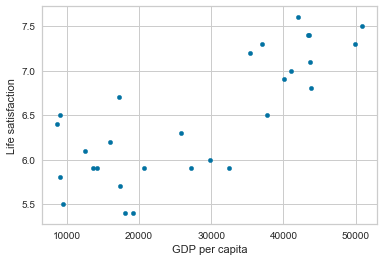

[[6.25984414]]


In [49]:
# Load the data
oecd_bli = pd.read_csv("data/oecd_bli_2015.csv", thousands=',')
gdp_per_capita = pd.read_csv("data/gdp_per_capita.csv",thousands=',',delimiter='\t',
                             encoding='latin1', na_values="n/a")

# Prepare the data
country_stats = prepare_country_stats(oecd_bli, gdp_per_capita)
X = np.c_[country_stats["GDP per capita"]]
y = np.c_[country_stats["Life satisfaction"]]

# Visualize the data
country_stats.plot(kind='scatter', x="GDP per capita", y='Life satisfaction')
plt.show()

# Select a linear model
model = sklearn.linear_model.LinearRegression()

# Train the model
model.fit(X, y)

# Make a prediction for Cyprus
X_new = [[22587]]  # Cyprus' GDP per capita
print(model.predict(X_new)) # outputs [[ 5.96242338]]

#### Step 2:  check the dimension of the table

In [50]:
print("The dimension of the table is: ", oecd_bli.shape)

The dimension of the table is:  (2368, 17)


#### Step 3:  Look at the data

In [51]:
print(oecd_bli.head(5))

  LOCATION         Country INDICATOR                 Indicator MEASURE  \
0      AUS       Australia   JE_LMIS  Labour market insecurity       L   
1      AUT         Austria   JE_LMIS  Labour market insecurity       L   
2      BEL         Belgium   JE_LMIS  Labour market insecurity       L   
3      CAN          Canada   JE_LMIS  Labour market insecurity       L   
4      CZE  Czech Republic   JE_LMIS  Labour market insecurity       L   

  Measure INEQUALITY Inequality Unit Code        Unit  PowerCode Code  \
0   Value        TOT      Total        PC  Percentage               0   
1   Value        TOT      Total        PC  Percentage               0   
2   Value        TOT      Total        PC  Percentage               0   
3   Value        TOT      Total        PC  Percentage               0   
4   Value        TOT      Total        PC  Percentage               0   

  PowerCode  Reference Period Code  Reference Period  Value  Flag Codes  Flags  
0     Units                    NaN 

In [52]:
oecd_bli.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2368 entries, 0 to 2367
Data columns (total 17 columns):
LOCATION                 2368 non-null object
Country                  2368 non-null object
INDICATOR                2368 non-null object
Indicator                2368 non-null object
MEASURE                  2368 non-null object
Measure                  2368 non-null object
INEQUALITY               2368 non-null object
Inequality               2368 non-null object
Unit Code                2368 non-null object
Unit                     2368 non-null object
PowerCode Code           2368 non-null int64
PowerCode                2368 non-null object
Reference Period Code    0 non-null float64
Reference Period         0 non-null float64
Value                    2368 non-null float64
Flag Codes               0 non-null float64
Flags                    0 non-null float64
dtypes: float64(5), int64(1), object(11)
memory usage: 314.6+ KB


**Looking at the results of the "info" method, there are a number of empty columns that can be removed.**  
There are also some with the same value throughout.

In [53]:
# Remove empty columns
oecd_bli.dropna(axis=1, inplace=True)

# Looks liks some other variables have the same value from top to bottom,
# so really don't need them...
print(oecd_bli['MEASURE'].value_counts())
print(oecd_bli['PowerCode Code'].value_counts())
oecd_bli.drop(['MEASURE', 'Measure', 'PowerCode Code'], axis = 1, inplace=True)

# Remove space from Unit Code
oecd_bli.rename(columns={'Unit Code': 'UnitCode'})

print(oecd_bli.info())

L    2368
Name: MEASURE, dtype: int64
0    2368
Name: PowerCode Code, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2368 entries, 0 to 2367
Data columns (total 10 columns):
LOCATION      2368 non-null object
Country       2368 non-null object
INDICATOR     2368 non-null object
Indicator     2368 non-null object
INEQUALITY    2368 non-null object
Inequality    2368 non-null object
Unit Code     2368 non-null object
Unit          2368 non-null object
PowerCode     2368 non-null object
Value         2368 non-null float64
dtypes: float64(1), object(9)
memory usage: 185.1+ KB
None


In [54]:
oecd_bli.sample(5)

,LOCATION,Country,INDICATOR,Indicator,INEQUALITY,Inequality,Unit Code,Unit,PowerCode,Value
748,CAN,Canada,SC_SNTWS,Quality of support network,TOT,Total,PC,Percentage,Units,93.00
696,SVK,Slovak Republic,JE_LTUR,Long-term unemployment rate,WMN,Women,PC,Percentage,Units,4.63
1645,HUN,Hungary,HS_SFRH,Self-reported health,TOT,Total,PC,Percentage,Units,60.00
1786,FIN,Finland,HS_SFRH,Self-reported health,LW,Low,PC,Percentage,Units,57.00
1791,IRL,Ireland,HS_SFRH,Self-reported health,LW,Low,PC,Percentage,Units,72.00


#### Using **pandas.pivot_table**, transform dataframe into a more human-friendly format...

In [55]:
df_table = pd.pivot_table(oecd_bli, values='Value', index='Country', columns=['INDICATOR'])

# I also need a 'Country' column. I know this is probably not the right way to go about this...
df_table['country'] = df_table.index.astype('str')

# Drop this row, it's not a country...
indexNames = df_table[df_table['country'] == 'OECD - Total'].index
df_table.drop(indexNames , inplace=True)

print(df_table.sample(5))

# For reference, create a dictionary of Indicators
print("LIST OF INDICATOR KEYS AND DESCRIPTIONS")
print("=======================================")
df_indicators = oecd_bli.groupby('INDICATOR')['Indicator'].agg('min')
print(df_indicators.sort_values())

INDICATOR        CG_SENG  CG_VOTO  EQ_AIRP   EQ_WATER    ES_EDUA   ES_EDUEX  \
Country                                                                       
Ireland              1.3     65.0      7.0  85.000000  82.000000  18.100000   
Netherlands          2.6     82.0     14.0  93.000000  78.333333  18.666667   
Norway               2.2     78.0      5.0  97.666667  82.000000  18.333333   
Hungary              1.2     70.0     19.0  77.000000  84.000000  16.433333   
Slovak Republic      3.0     60.0     21.0  84.666667  91.333333  15.766667   

INDICATOR        ES_STCS  HO_BASE  HO_HISH  HO_NUMR     HS_LEB  HS_SFRH  \
Country                                                                   
Ireland            509.8      1.0     20.0      2.1  81.766667     82.8   
Netherlands        509.6      0.1     19.0      1.9  81.600000     75.8   
Norway             504.8      0.0     17.0      2.1  82.466667     77.2   
Hungary            475.0      4.7     19.0      1.2  76.166667     61.0

In [56]:
df_table.describe()

INDICATOR,CG_SENG,CG_VOTO,EQ_AIRP,EQ_WATER,ES_EDUA,ES_EDUEX,ES_STCS,HO_BASE,HO_HISH,HO_NUMR,HS_LEB,HS_SFRH,IW_HADI,IW_HNFW,JE_EMPL,JE_LMIS,JE_LTUR,JE_PEARN,PS_FSAFEN,PS_REPH,SC_SNTWS,SW_LIFS,WL_EWLH,WL_TNOW
count,38.000000,40.00000,40.000000,40.000000,39.000000,39.000000,39.000000,37.000000,38.000000,37.000000,40.000000,37.000000,29.000000,27.000000,40.000000,33.000000,38.000000,35.000000,40.000000,40.000000,40.000000,40.000000,38.000000,22.000000
mean,2.160526,69.57500,13.325000,82.333333,77.717949,17.547863,485.707692,5.075676,20.657895,1.632432,79.567500,67.493243,27807.310345,289780.185185,68.533333,7.706970,2.855789,39817.514286,68.463333,3.481667,90.193333,6.577208,7.789649,15.048939
std,0.577291,12.21157,5.770782,10.492977,15.136134,1.412720,33.787972,8.448320,2.528500,0.431441,4.669642,14.331584,7055.262661,165673.432787,7.882253,6.234572,3.622899,13108.329748,13.960934,6.459861,4.384954,0.762724,7.585983,0.672978
min,1.200000,47.00000,3.000000,55.333333,37.666667,14.100000,398.200000,0.000000,15.000000,0.900000,57.500000,33.000000,16275.000000,70160.000000,43.333333,0.662000,0.050000,15314.000000,35.866667,0.166667,78.333333,4.700000,0.140000,13.826667
25%,1.725000,60.75000,9.750000,74.250000,75.000000,16.550000,475.800000,0.300000,19.000000,1.200000,77.916667,60.800000,21453.000000,180100.000000,65.833333,4.392000,1.011667,25971.500000,60.108333,0.600000,88.300000,5.938333,3.150833,14.560833
50%,2.200000,69.50000,14.000000,83.833333,82.000000,17.666667,492.800000,0.900000,21.000000,1.600000,81.366667,70.200000,29333.000000,259667.000000,69.666667,5.396000,1.776667,40863.000000,70.483333,0.950000,91.350000,6.510000,4.981667,14.885000
75%,2.575000,79.00000,16.500000,91.083333,87.833333,18.350000,506.800000,6.700000,22.750000,1.900000,82.366667,76.000000,31304.000000,379777.000000,74.000000,8.784000,3.196667,49400.500000,78.500000,2.166667,93.062500,7.243750,10.571667,15.600833
max,3.200000,91.00000,28.000000,98.666667,94.000000,20.966667,528.800000,37.000000,26.000000,2.600000,84.066667,89.250000,45284.000000,769053.000000,85.666667,29.200000,16.643333,63062.000000,90.033333,27.000000,98.000000,7.660000,31.043333,16.336667


In [57]:
corr_matrix = df_table.corr()
corr_matrix["SW_LIFS"].sort_values(ascending=False)

INDICATOR
SW_LIFS      1.000000
JE_PEARN     0.731418
IW_HADI      0.713008
EQ_WATER     0.682587
JE_EMPL      0.678344
SC_SNTWS     0.667896
HS_SFRH      0.656817
PS_FSAFEN    0.600163
HO_NUMR      0.597502
HS_LEB       0.568044
CG_VOTO      0.368598
ES_EDUEX     0.324655
ES_EDUA      0.293395
IW_HNFW      0.292887
HO_HISH      0.286334
WL_TNOW      0.199424
ES_STCS      0.197223
CG_SENG      0.180861
WL_EWLH     -0.195136
PS_REPH     -0.259378
JE_LMIS     -0.452874
HO_BASE     -0.528167
EQ_AIRP     -0.551376
JE_LTUR     -0.567002
Name: SW_LIFS, dtype: float64

#### Step 4: Think about some questions that might help you predict what indicators most influence the Life Satisfaction score:

The central point of this dataset is the so-called, **"Life Satisfaction Index"**. In other words, do indicators in the categories of housing, income, jobs, community, education, environment, civic engagement, health, etc. really lead to a better, more satisfied life? Let's focus on a few high-level categories to see how the indicators correlate with the LSI...

* **Wealth** Net Wealth, Labor Market Insecurity, Employment rate
* **Environment** Air pollution, Homicide rate, Water quality
* **Health** Life expectancy, Self-reported health, Long work hours

My observations are based on the **graph analysis** below.

First, there does not seem to be any noticeable normal distribution amongst any of the indicators, although some--such as HS_LEB (Life Expectancy) exhibit *normal-ish* distribution on a skewed scale.

* **Wealth** - somewhat surprisingly, Net Wealth does not appear to be as important as labor market security and the employment rate. Having said that, removing the data points above $500,000 might tell a different story.
* **Environment** - Air and water quality seem to factor higher than the homicide rate, which shows almost no effect on the LSI.
* **Health** - Life expectancy seems like an obvious factor, but I was also satisfied to see long work hours affect the index as well.

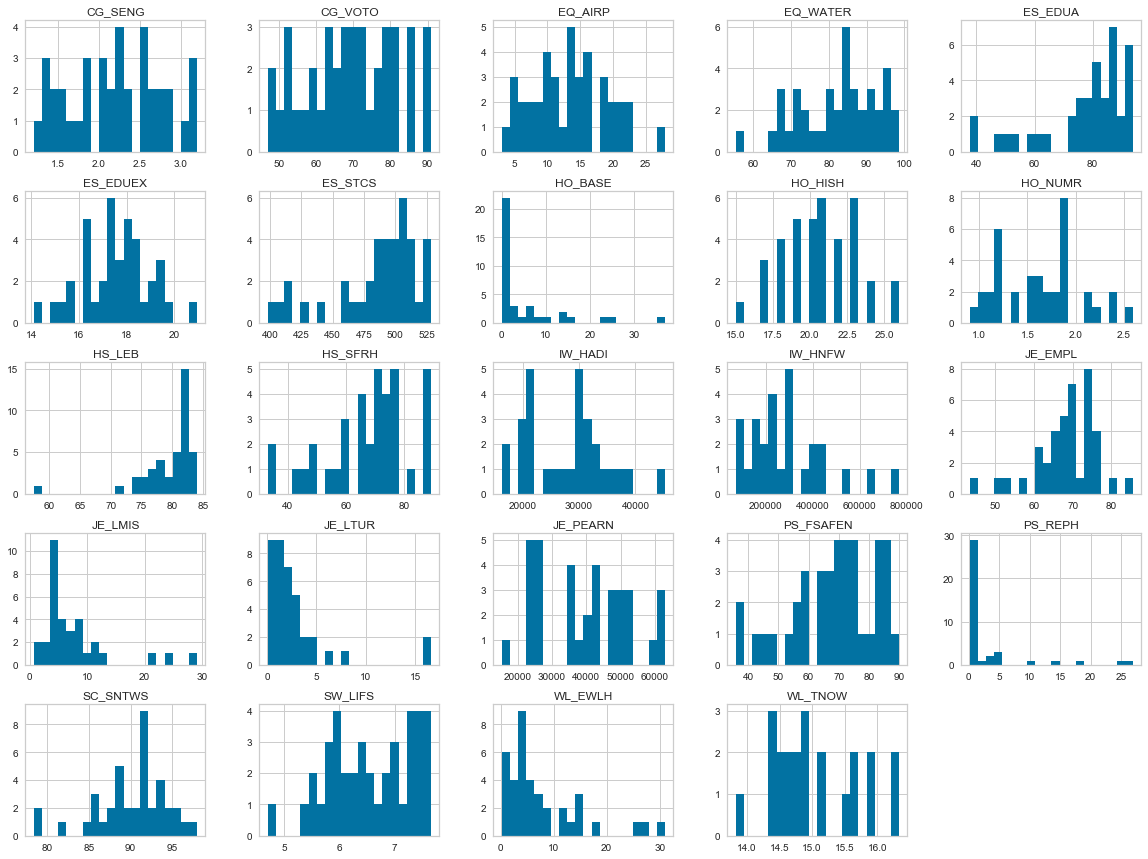

In [58]:
df_table.hist( bins = 20, figsize =( 20,15)) 
plt.show()

In [59]:
results = smf.ols('SW_LIFS ~ IW_HNFW + JE_LMIS + JE_EMPL', data=df_table).fit()
print("Money: Net Wealth, Labor Market Insecurity, Employment rate")
print(results.summary())

Money: Net Wealth, Labor Market Insecurity, Employment rate
                            OLS Regression Results                            
Dep. Variable:                SW_LIFS   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     3.564
Date:                Sat, 01 Feb 2020   Prob (F-statistic):             0.0306
Time:                        13:14:13   Log-Likelihood:                -22.710
No. Observations:                  26   AIC:                             53.42
Df Residuals:                      22   BIC:                             58.45
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000247E299AD30>,
      dtype=object)

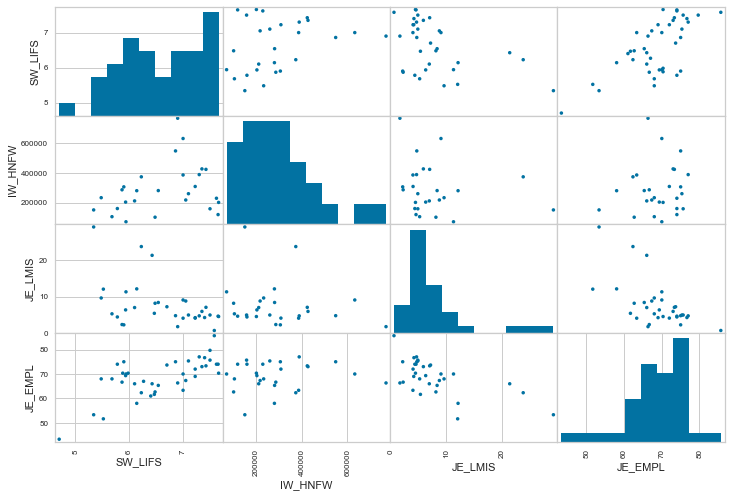

In [60]:
attributes = ['SW_LIFS', 'IW_HNFW', 'JE_LMIS', 'JE_EMPL']
scatter_matrix(df_table[attributes], alpha=1.0, figsize=(12, 8))

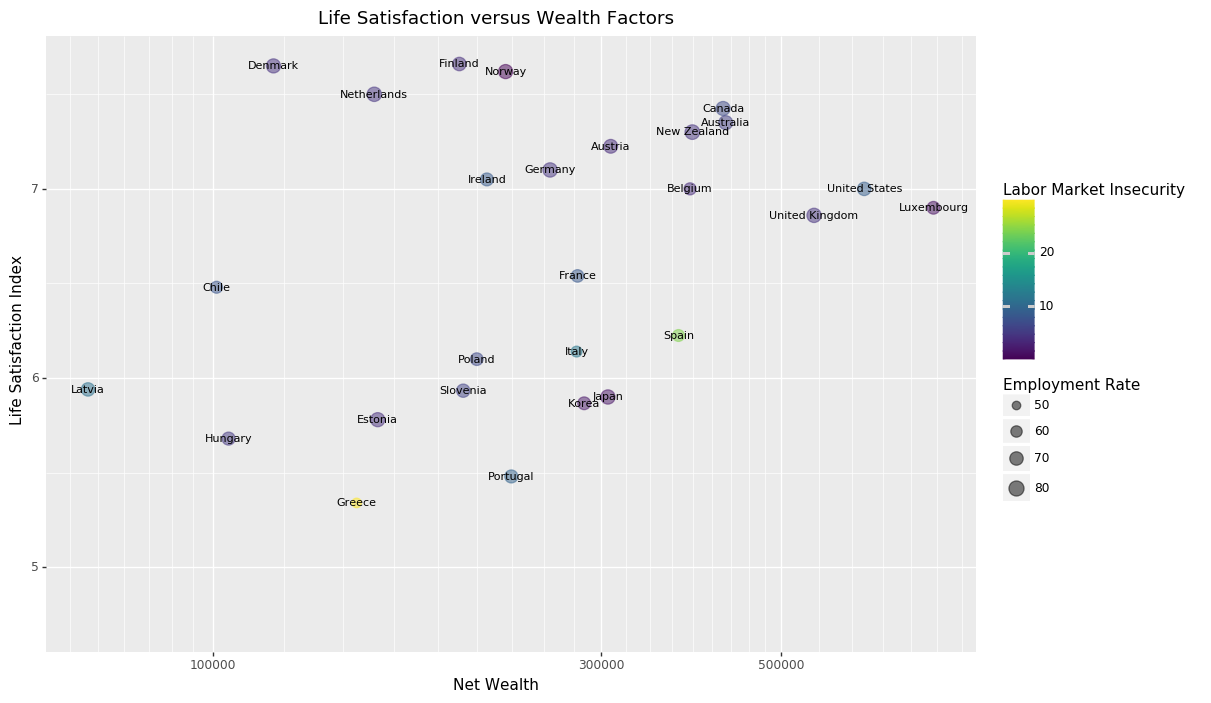

<ggplot: (156738463305)>

In [61]:
(ggplot(df_table, aes(x='IW_HNFW', y='SW_LIFS', color='JE_LMIS', size='JE_EMPL')) +
        geom_point(alpha=0.5) +
        scale_x_log10() +
        geom_text(aes(x='IW_HNFW', y='SW_LIFS', label='country'),
                  color="black",
                  size=8,
                  data=df_table) +
         theme(figure_size = (12.0, 8.0)) +
        labs(title="Life Satisfaction versus Wealth Factors",x="Net Wealth",y="Life Satisfaction Index",size="Employment Rate",color="Labor Market Insecurity")
)

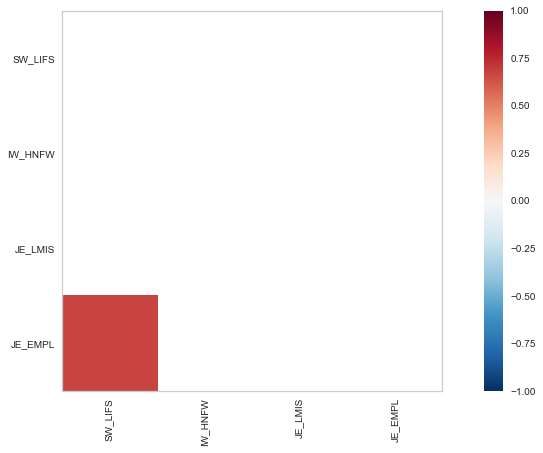

In [62]:
import yellowbrick
from yellowbrick.features import Rank2D
from yellowbrick.features import ParallelCoordinates
from yellowbrick.style import set_palette

#set up the figure size
plt.rcParams['figure.figsize'] = (15, 7)
num_features = ['SW_LIFS', 'IW_HNFW', 'JE_LMIS', 'JE_EMPL']
# extract the numpy arrays from the data frame
X = df_table[num_features].as_matrix()

# instantiate the visualizer with the Covariance ranking algorithm
visualizer = Rank2D(features=num_features, algorithm='pearson')
visualizer.fit(X)                # Fit the data to the visualizer
visualizer.transform(X)             # Transform the data

plt.show()

In [63]:
results = smf.ols('SW_LIFS ~ EQ_AIRP + PS_REPH + EQ_WATER', data=df_table).fit()
print("Environment: Air pollution, Homicide rate, Water quality")
print(results.summary())

Environment: Air pollution, Homicide rate, Water quality
                            OLS Regression Results                            
Dep. Variable:                SW_LIFS   R-squared:                       0.512
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     12.57
Date:                Sat, 01 Feb 2020   Prob (F-statistic):           8.92e-06
Time:                        13:14:15   Log-Likelihood:                -31.080
No. Observations:                  40   AIC:                             70.16
Df Residuals:                      36   BIC:                             76.92
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000247E4E78130>,
      dtype=object)

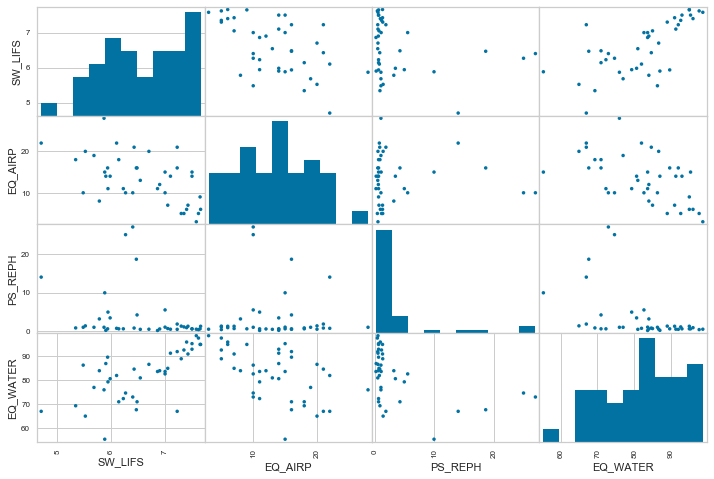

In [64]:
attributes = ['SW_LIFS', 'EQ_AIRP', 'PS_REPH', 'EQ_WATER']
scatter_matrix(df_table[attributes], alpha=1.0, figsize=(12, 8))

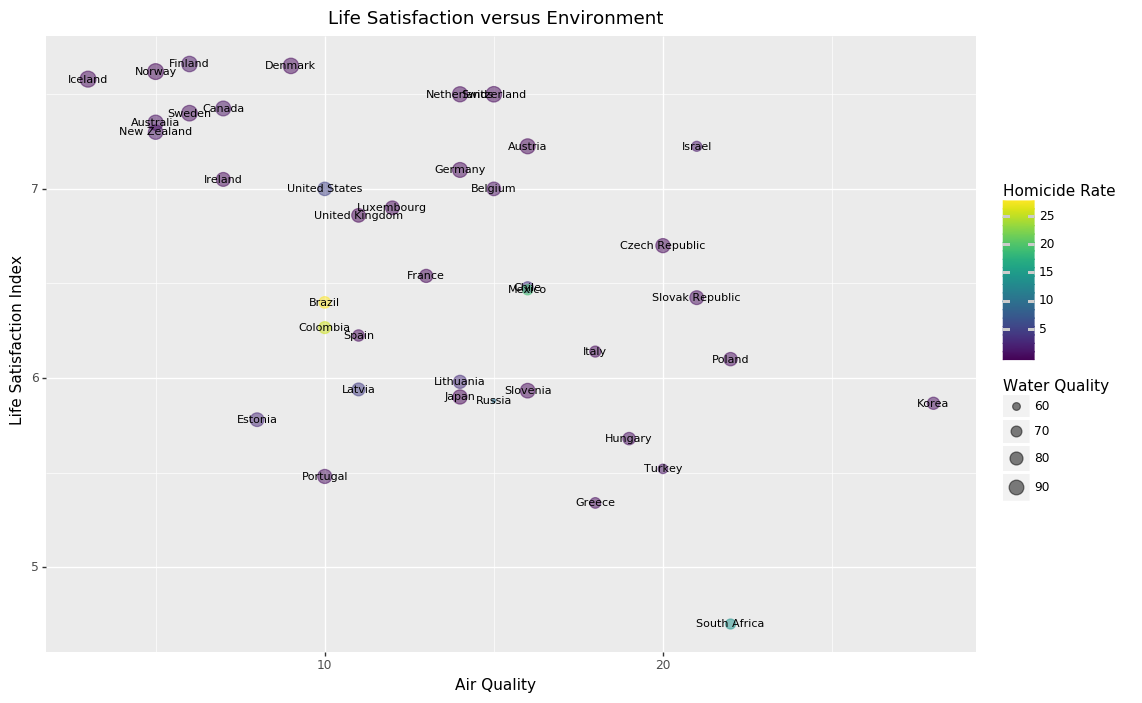

<ggplot: (156737894614)>

In [65]:
(ggplot(df_table, aes(x='EQ_AIRP', y='SW_LIFS', color='PS_REPH', size='EQ_WATER')) +
        geom_point(alpha = 0.5) +
         geom_text(aes(x='EQ_AIRP', y='SW_LIFS', label='country'),
                  color="black",
                  size=8,
                  data=df_table) +
        theme(figure_size = (12.0, 8.0)) +
        labs(title="Life Satisfaction versus Environment",x="Air Quality",y="Life Satisfaction Index",size="Water Quality",color="Homicide Rate")
)

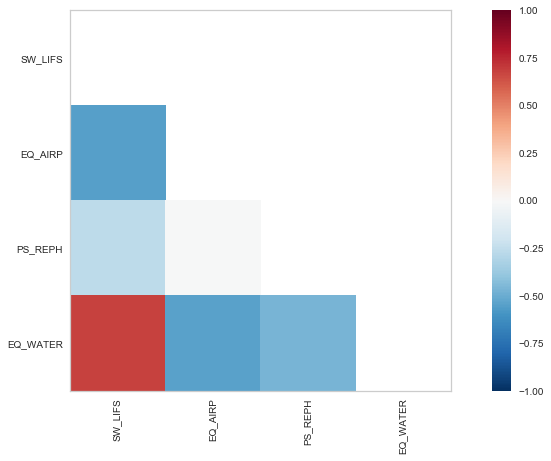

In [66]:
#set up the figure size
plt.rcParams['figure.figsize'] = (15, 7)
num_features = ['SW_LIFS', 'EQ_AIRP', 'PS_REPH', 'EQ_WATER']
# extract the numpy arrays from the data frame
X = df_table[num_features].as_matrix()

# instantiate the visualizer with the Covariance ranking algorithm
visualizer = Rank2D(features=num_features, algorithm='pearson')
visualizer.fit(X)                # Fit the data to the visualizer
visualizer.transform(X)             # Transform the data

plt.show()

In [67]:
results = smf.ols('SW_LIFS ~ HS_LEB + HS_SFRH + WL_EWLH', data=df_table).fit()
print("Health: Life expectancy, Self-reported health, Long work hours")
print(results.summary())

Health: Life expectancy, Self-reported health, Long work hours
                            OLS Regression Results                            
Dep. Variable:                SW_LIFS   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.434
Method:                 Least Squares   F-statistic:                     9.707
Date:                Sat, 01 Feb 2020   Prob (F-statistic):           0.000114
Time:                        13:14:16   Log-Likelihood:                -26.111
No. Observations:                  35   AIC:                             60.22
Df Residuals:                      31   BIC:                             66.44
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000247E542DC10>,
      dtype=object)

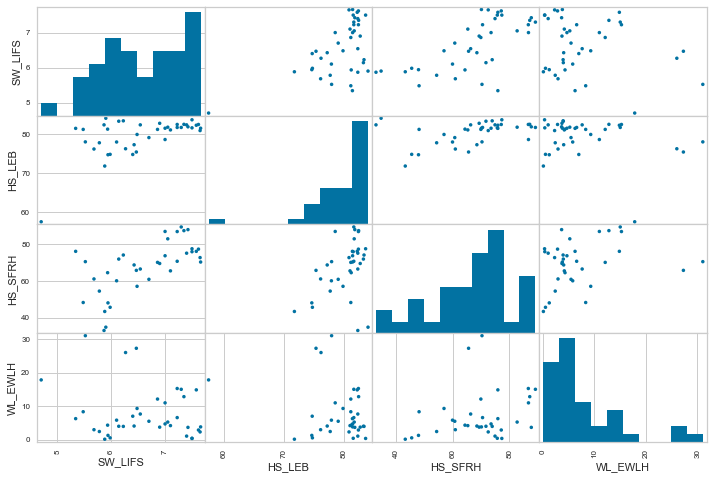

In [68]:
attributes = ['SW_LIFS', 'HS_LEB', 'HS_SFRH', 'WL_EWLH']
scatter_matrix(df_table[attributes], alpha=1.0, figsize=(12, 8))

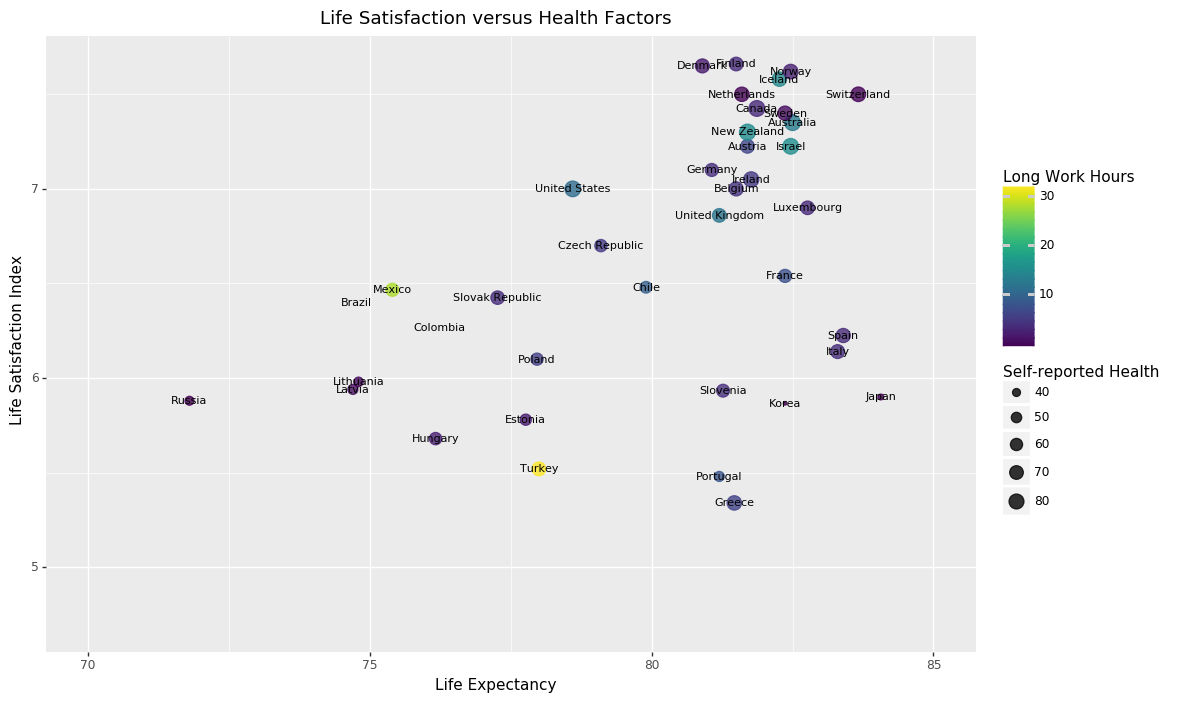

<ggplot: (156737931379)>

In [69]:
(ggplot(df_table[df_table['HS_LEB'] > 70], aes(x='HS_LEB', y='SW_LIFS', color='WL_EWLH', size='HS_SFRH')) +
        geom_point(alpha = 0.8) +
        scale_x_continuous(limits=[70,85]) +
        geom_text(aes(x='HS_LEB', y='SW_LIFS', label='country'),
                  color="black",
                  size=8,
                  data=df_table) +
        theme(figure_size = (12.0, 8.0)) +
        labs(title="Life Satisfaction versus Health Factors",x="Life Expectancy",y="Life Satisfaction Index",size="Self-reported Health",color="Long Work Hours")
)


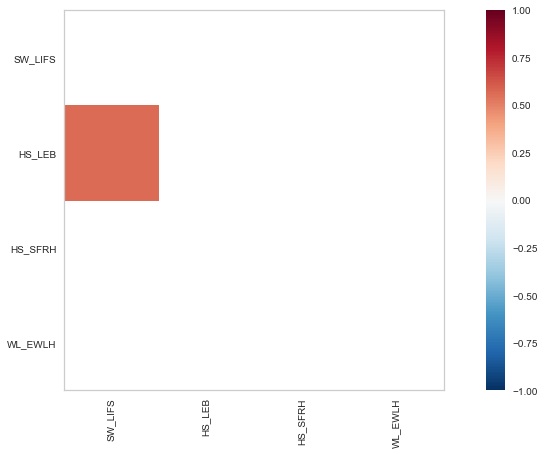

In [70]:
#set up the figure size
plt.rcParams['figure.figsize'] = (15, 7)
num_features = ['SW_LIFS', 'HS_LEB', 'HS_SFRH', 'WL_EWLH']
# extract the numpy arrays from the data frame
X = df_table[num_features].as_matrix()

# instantiate the visualizer with the Covariance ranking algorithm
visualizer = Rank2D(features=num_features, algorithm='pearson')
visualizer.fit(X)                # Fit the data to the visualizer
visualizer.transform(X)             # Transform the data

plt.show()

*************************************************
#### Part 2: Dimensionality and Feature Reduction


In [71]:
# What kind of data are we dealing with?
df_table.describe()

INDICATOR,CG_SENG,CG_VOTO,EQ_AIRP,EQ_WATER,ES_EDUA,ES_EDUEX,ES_STCS,HO_BASE,HO_HISH,HO_NUMR,HS_LEB,HS_SFRH,IW_HADI,IW_HNFW,JE_EMPL,JE_LMIS,JE_LTUR,JE_PEARN,PS_FSAFEN,PS_REPH,SC_SNTWS,SW_LIFS,WL_EWLH,WL_TNOW
count,38.000000,40.00000,40.000000,40.000000,39.000000,39.000000,39.000000,37.000000,38.000000,37.000000,40.000000,37.000000,29.000000,27.000000,40.000000,33.000000,38.000000,35.000000,40.000000,40.000000,40.000000,40.000000,38.000000,22.000000
mean,2.160526,69.57500,13.325000,82.333333,77.717949,17.547863,485.707692,5.075676,20.657895,1.632432,79.567500,67.493243,27807.310345,289780.185185,68.533333,7.706970,2.855789,39817.514286,68.463333,3.481667,90.193333,6.577208,7.789649,15.048939
std,0.577291,12.21157,5.770782,10.492977,15.136134,1.412720,33.787972,8.448320,2.528500,0.431441,4.669642,14.331584,7055.262661,165673.432787,7.882253,6.234572,3.622899,13108.329748,13.960934,6.459861,4.384954,0.762724,7.585983,0.672978
min,1.200000,47.00000,3.000000,55.333333,37.666667,14.100000,398.200000,0.000000,15.000000,0.900000,57.500000,33.000000,16275.000000,70160.000000,43.333333,0.662000,0.050000,15314.000000,35.866667,0.166667,78.333333,4.700000,0.140000,13.826667
25%,1.725000,60.75000,9.750000,74.250000,75.000000,16.550000,475.800000,0.300000,19.000000,1.200000,77.916667,60.800000,21453.000000,180100.000000,65.833333,4.392000,1.011667,25971.500000,60.108333,0.600000,88.300000,5.938333,3.150833,14.560833
50%,2.200000,69.50000,14.000000,83.833333,82.000000,17.666667,492.800000,0.900000,21.000000,1.600000,81.366667,70.200000,29333.000000,259667.000000,69.666667,5.396000,1.776667,40863.000000,70.483333,0.950000,91.350000,6.510000,4.981667,14.885000
75%,2.575000,79.00000,16.500000,91.083333,87.833333,18.350000,506.800000,6.700000,22.750000,1.900000,82.366667,76.000000,31304.000000,379777.000000,74.000000,8.784000,3.196667,49400.500000,78.500000,2.166667,93.062500,7.243750,10.571667,15.600833
max,3.200000,91.00000,28.000000,98.666667,94.000000,20.966667,528.800000,37.000000,26.000000,2.600000,84.066667,89.250000,45284.000000,769053.000000,85.666667,29.200000,16.643333,63062.000000,90.033333,27.000000,98.000000,7.660000,31.043333,16.336667


**Proposed Steps for Dimensionality and Feature Reduction**  

* The *variance* between features varies greatly, For example, CG_SENS ranges from 1.2 to 3.2 while SC_SNTWS ranges from 4.38 to 98. I will start by setting a variance threshold and eliminating features below the threshold. In theory, this should eliminate variables with low variance, which likely will not contribute greatly to the model.
* Due to the quantitative nature of these variables, there exists wide discrepancies of units. For instance, Household Net Wealth can be in the thousands of US dollars, while Employment Rate is a percentage. I will apply both aa simple `min-max rescaler` to normalize all variables, and a `standard scaler` to standardize the variables.
* I suspect that variables such as air pollution and water quality probably are highly correlated. I will apply a correlation matrix and will consider dropping one of the correlated features.
* Lastly, I'd like to automatically select the best features to keep by leveraging scikit-learn's `recursive feature elimination functionality`.

[VarianceThreshold](https://stackoverflow.com/questions/29298973/removing-features-with-low-variance-using-scikit-learn/29301500)

In [72]:
# Make a features DataFrame by dropping the target variable--SW_LIFS--and assigning that to a target Series,
features = df_table.drop(['country','SW_LIFS'], axis=1)
target = df_table['SW_LIFS']

In [73]:
# Apply a Variance Threshold to remove those features with low variance
from sklearn.feature_selection import VarianceThreshold

# Make a features dataset by dropping the target variable--SW_LIFS
features = df_table.drop(['country','SW_LIFS'], axis=1)
target = df_table['SW_LIFS']

# Create thresholder
thresholder = VarianceThreshold(threshold=5.0)

# Create high variance feature matrix
features_high_variance = thresholder.fit_transform(features)

features_vt = features.loc[:, thresholder.get_support()]
features_vt.head()

INDICATOR,CG_VOTO,EQ_AIRP,EQ_WATER,ES_EDUA,ES_STCS,HO_BASE,HO_HISH,HS_LEB,HS_SFRH,IW_HADI,IW_HNFW,JE_EMPL,JE_LMIS,JE_LTUR,JE_PEARN,PS_FSAFEN,PS_REPH,SC_SNTWS,WL_EWLH
Country,,,,,,,,,,,,,,,,,,,
Australia,91.0,5.0,92.666667,81.000000,411.2,NaN,20.0,82.500000,87.25,32759.0,427064.0,73.000000,5.922,1.306667,49126.0,64.133333,1.100000,95.25,12.840000
Austria,80.0,16.0,92.000000,85.000000,492.8,0.9,21.0,81.700000,70.60,33541.0,308325.0,72.000000,4.076,1.830000,50349.0,80.700000,0.466667,92.00,6.590000
Belgium,89.0,15.0,83.666667,77.000000,503.8,1.9,21.0,81.500000,73.60,30364.0,386006.0,63.333333,4.052,3.533333,49675.0,70.266667,1.033333,92.00,4.703333
Brazil,79.0,10.0,73.000000,49.000000,398.2,6.7,NaN,74.766667,NaN,NaN,NaN,61.000000,NaN,NaN,NaN,35.866667,27.000000,89.25,7.006667
Canada,68.0,7.0,91.000000,91.333333,523.2,0.2,22.0,81.866667,87.80,30854.0,423849.0,73.333333,7.048,0.763333,47622.0,82.500000,1.266667,93.25,3.673333


**Not terribly surprising to see which features the `Variance Thesholder` dropped:**  

Stakeholder engagement for developing regulations  
Years in education  
Rooms per person  
Time devoted to leisure and personal care  

In [74]:
from sklearn import preprocessing

# Standardizing
std_scale = preprocessing.StandardScaler().fit(features_vt)
df_std = std_scale.transform(features_vt)
standardized_df = pd.DataFrame(df_std, index=features_vt.index, columns=features_vt.columns)

#Min-max scaling (normalization)
minmax_scale = preprocessing.MinMaxScaler().fit(features_vt)
df_minmax = minmax_scale.transform(features_vt)
scaled_features_df = pd.DataFrame(df_minmax, index=features_vt.index, columns=features_vt.columns)

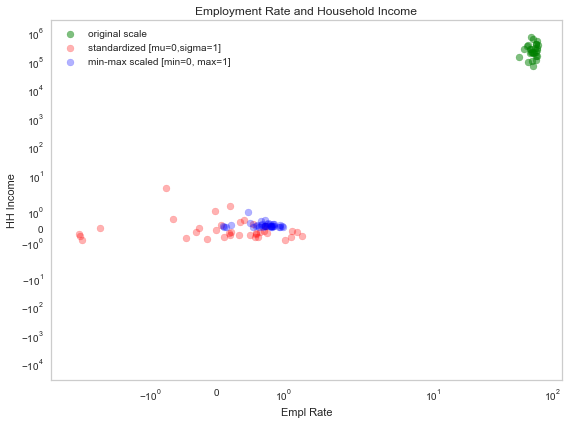

In [75]:
def plot():
    plt.figure(figsize=(8,6))

    plt.scatter(df_table['JE_EMPL'], df_table['IW_HNFW'],
            color='green', label='original scale', alpha=0.5)

    plt.scatter(df_std[:,4], df_std[:,13], color='red',
            label='standardized [mu=0,sigma=1]', alpha=0.3)

    plt.scatter(df_minmax[:,4], df_minmax[:,13],
            color='blue', label='min-max scaled [min=0, max=1]', alpha=0.3)

    plt.title('Employment Rate and Household Income')
    plt.xlabel('Empl Rate')
    plt.ylabel('HH Income')
    plt.legend(loc='upper left')
    plt.xscale('symlog')
    plt.yscale('symlog')
    plt.grid()

    plt.tight_layout()

plot()
plt.show()

At this point I made a more or less arbitrary decision to go with the `standardized` feature set over the `min max scaled`...

In [82]:
# Create correlation matrix
corr_matrix = standardized_df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),
                          k=1).astype(np.bool))
upper.fillna(0, inplace=True)

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features
standardized_df.drop(standardized_df.columns[to_drop], axis=1, inplace=True)
features = standardized_df
print(features.shape)
features.sample(5)

(40, 19)


INDICATOR,CG_VOTO,EQ_AIRP,EQ_WATER,ES_EDUA,ES_STCS,HO_BASE,HO_HISH,HS_LEB,HS_SFRH,IW_HADI,IW_HNFW,JE_EMPL,JE_LMIS,JE_LTUR,JE_PEARN,PS_FSAFEN,PS_REPH,SC_SNTWS,WL_EWLH
Country,,,,,,,,,,,,,,,,,,,
Czech Republic,-0.711149,1.171425,0.418236,1.067459,0.194660,-0.525079,1.339516,-0.101390,-0.473470,-0.916590,NaN,0.659549,-0.081274,-0.503264,-1.118099,0.295242,-0.467448,0.359524,-0.306323
Mexico,-0.545283,0.469447,-1.415567,-2.680661,-2.090062,2.450908,-0.263684,-0.903836,-0.129209,NaN,NaN,-0.882253,-0.376417,-0.780194,-1.896599,-1.922093,2.375390,-1.984698,2.603747
France,0.449910,-0.057036,-0.128688,0.041188,0.350573,-0.549079,0.137116,0.607076,-0.077334,0.504387,-0.056141,-0.411147,0.109625,0.319134,0.304766,0.162250,-0.472674,-0.275610,-0.017765
New Zealand,0.864574,-1.460990,0.643439,0.063498,0.614426,NaN,2.141117,0.462491,1.539039,NaN,0.607307,1.087827,-0.489784,-0.592776,0.017453,-0.159348,-0.342029,1.398835,0.968140
Lithuania,-1.540476,0.118459,-0.160860,1.000529,-0.273078,1.022914,-0.664485,-1.033963,-1.548694,-0.886731,NaN,0.231270,NaN,-0.044511,-1.202079,-0.887176,-0.007577,-0.414184,-0.967601


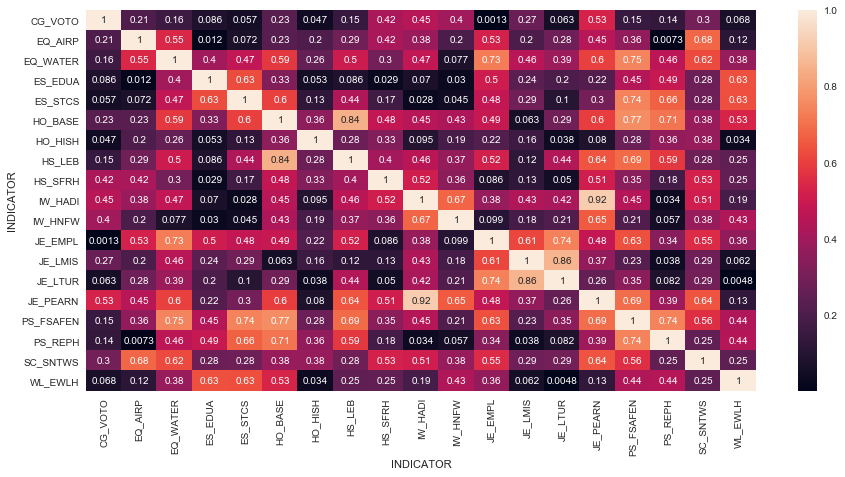

In [83]:
import seaborn as sns
# print(corr_matrix)
sns.heatmap(corr_matrix, annot=True)

There are no features with a correlation of > 95%. If I drop the threshold to 90% there is one:  

JE_PEARN and IW_HADI (Personal Income and Household disposable income)

Although not surprising as they are similar measurements, I will leave them both in.

In [86]:
# Apply Recursive Feature Elimination

# Load libraries
import warnings
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor

# Suppress an annoying but harmless warning
warnings.filterwarnings(action="ignore", module="scipy",
                        message="^internal gelsd")

# Need to fix the NaN's before we can successfully apply a model
features = features.fillna(features.median())
randomforest = RandomForestRegressor(random_state=0, n_jobs=-1)

# Recursively eliminate features
rfecv = RFECV(estimator=randomforest, step=1, scoring="neg_mean_squared_error")
rfecv.fit(features, target)
rfecv.transform(features)

Number of features we should keep: 15



In [97]:

# Once we have conducted RFE, we can see the number of features we should keep: 
# Number of best features
print("Number of features we should keep: {}".format(rfecv.n_features_))
print()

# We can also see which of those features we should keep: 
# Which categories are best
print(rfecv.support_)

# Rank features best (1) to worst
print(rfecv.ranking_)

df_rfecv = pd.DataFrame(features.columns, rfecv.ranking_)
print(df_rfecv.sort_values)

Number of features we should keep: 15

[False False  True  True  True  True  True  True  True  True False  True
  True  True  True  True False  True  True]
[5 3 1 1 1 1 1 1 1 1 4 1 1 1 1 1 2 1 1]
<bound method DataFrame.sort_values of    INDICATOR
5    CG_VOTO
3    EQ_AIRP
1   EQ_WATER
1    ES_EDUA
1    ES_STCS
1    HO_BASE
1    HO_HISH
1     HS_LEB
1    HS_SFRH
1    IW_HADI
4    IW_HNFW
1    JE_EMPL
1    JE_LMIS
1    JE_LTUR
1   JE_PEARN
1  PS_FSAFEN
2    PS_REPH
1   SC_SNTWS
1    WL_EWLH>


I have mixed feelings about these results, so I opted to drop the two with the lowest ranking: `CG_VOTO` (Voter Turnout) and `IW_HNFW` (Household Net  Wealth).

In [101]:
features.drop(['CG_VOTO', 'IW_HNFW'], axis=1, inplace=True)
features.sample(3)

INDICATOR,EQ_AIRP,EQ_WATER,ES_EDUA,ES_STCS,HO_BASE,HO_HISH,HS_LEB,HS_SFRH,IW_HADI,JE_EMPL,JE_LMIS,JE_LTUR,JE_PEARN,PS_FSAFEN,PS_REPH,SC_SNTWS,WL_EWLH
Country,,,,,,,,,,,,,,,,,
Slovak Republic,1.346919,0.225204,0.911288,-0.668857,-0.465079,0.938716,-0.498999,0.078290,-1.057808,-0.325491,2.226451,0.536389,-1.198906,-0.345537,-0.420416,0.301785,-0.496468
Poland,1.522413,-0.032172,0.955908,0.590439,-0.249080,0.537916,-0.347184,-0.530060,-1.153011,-0.325491,-0.117759,-0.375522,-0.988529,-0.072299,-0.430868,-0.968483,-0.262683
Luxembourg,-0.232530,0.160860,-0.070363,-0.009226,-0.549079,0.137116,0.693827,0.134881,1.652593,-0.282664,-0.974849,-0.143348,1.799149,0.537045,-0.456997,0.648222,-0.540999


******************************************
### Part 3: Model Evaluation and Selection

**Model Selection**

I've decided to start with a **Random Forest Regression** model, leveraging scikit-learn's `RandomForestRegressorer`. This model takes advantage of the *ensemble learning method*, where multiple decision trees are trained, although each tree only receives a "bootstrapped" sample of observations. [1] 

In order to "dial in" my model, I plan to leverage the **feature_importances_** of the RandomForestClassifier model, as well as **SelectFromModel** method from scikit-learn's `feature_selection` library.

**Model Evaluation**

This topic can get a little overwhelming, as, from the reading I've done, there appears to be a bewildering number of approaches to model evaluation. Given the constraints of one semester's worth of time, I'm going to focus on the following:

* Calculate the **Mean Squared Error**
* Calculate the **Coefficient of Determination *(R squared)***

**References**  
[1] Albon, Chris. Machine Learning with Python Cookbook: Practical Solutions from Preprocessing to Deep Learning (p. 238). O'Reilly Media. Kindle Edition. 

#### Model Selection

In [102]:
# Apply a Random Forest Regressor Model and train (fit) it.
from sklearn.ensemble import RandomForestRegressor

# Create random forest classifier object
randomforest = RandomForestRegressor(random_state=0, n_jobs=-1)

# Train model
model = randomforest.fit(features, target)

In [103]:
# Calculate feature importances
importances = model.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [features.columns[i] for i in indices]

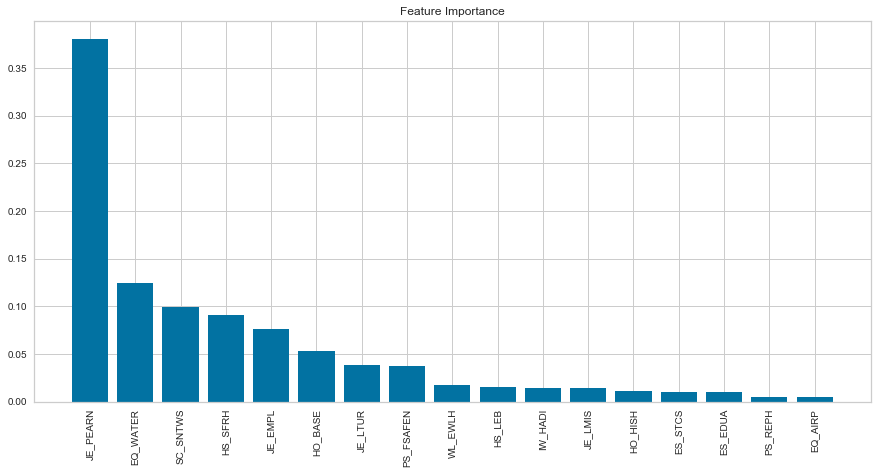

In [104]:
# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(features.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(features.shape[1]), names, rotation=90)

# Show plot
plt.show()

**Based on the results above, I'm dropping all but the highest rated columns above 0.5.**

*Interesting observation. I've been resisting dropping `EQ_AIRP`--Air Quality--because I just can't believe it's not important. But many of the calculations I've run have suggested eliminating it.*

In [107]:
new_features = ['JE_PEARN', 'EQ_WATER', 'SC_SNTWS', 'HS_SFRH', 'JE_EMPL', 'HO_BASE']
features_final = features[new_features]

# Re-train the model on the new feature set
model = randomforest.fit(features_final, target)

**SelectFromModel** is returning dubious results (I'm sure it's something I'm doing wrong) so dropping this for now...

In [ ]:
# from sklearn.feature_selection import SelectFromModel

# # Create object that selects features with importance greater
# # than or equal to a threshold
# selector = SelectFromModel(randomforest, threshold=0.3)

# # Feature new feature matrix using selector
# features_important = selector.fit_transform(features, target)

# # Sort feature importances in descending order
# indices = np.argsort(features_important)[::-1]

# # Rearrange feature names so they match the sorted feature importances
# names = [features.columns for i in indices]

# # Create plot
# plt.figure()

# # Create plot title
# plt.title("Feature Importance")

# # Add bars
# plt.bar(range(features.shape[1]), features_important[indices])

# # Add feature names as x-axis labels
# plt.xticks(range(features.shape[1]), names, rotation=90)

# # Show plot
# plt.show()

# Train random forest using most important features
# model = randomforest.fit(features_important, target)

#### Model Evaluation

In [125]:
# Cross-validate the random forest regression using (negative) MSE, RMSE and R-squared
from sklearn.model_selection import cross_val_score
scorers = ['neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2']

for scorer in scorers:
    cvs = cross_val_score(randomforest, features, target, scoring=scorer)
    print("{}\t\t{}".format(scorer, cvs))

neg_mean_absolute_error		[-0.2856625  -0.46934375 -0.3044625  -0.28794583 -0.47037917]
neg_root_mean_squared_error		[-0.33881842 -0.5923367  -0.49264287 -0.35860543 -0.66774549]
r2		[0.36472877 0.56892412 0.16964655 0.76679536 0.46711817]


**************
#### References

http://sebastianraschka.com/Articles/2014_about_feature_scaling.html#standardization-and-min-max-scaling  

Albon, Chris. Machine Learning with Python Cookbook: Practical Solutions from Preprocessing to Deep Learning . O'Reilly Media. Kindle Edition. 
